In [1]:
import os
import numpy as np
import seaborn as sns
import pandas as pd
from scipy.signal import find_peaks, butter, filtfilt
from sklearn.cluster import KMeans
from sklearn.mixture import GaussianMixture
from sklearn.manifold import TSNE, MDS
import umap

/Users/drewbheadley/opt/anaconda3/envs/spikesort-env/lib/python3.10/site-packages/tqdm/auto.py:22: TqdmWarning: IProgress not found. Please update jupyter and ipywidgets. See https://ipywidgets.readthedocs.io/en/stable/user_install.html
  from .autonotebook import tqdm as notebook_tqdm


### Stages of classical spike soritng
Traditionally spike sorting was divided into four steps:

1. **Preprocessing of extracellular trace:** Raw extracellular recordings contain low frequency (less than ~200 Hz) activity 'local field potentials', higher frequency noise (greater than ~6 kHz), and action potential related signals (between 300 and 6000Hz). Removal of shared noise or correlations across electrodes can also be performed.
2. **Detection of spiking events:** Spiking events are detected as deviations from the recording 'noise' and snippets of waveforms around these points are taken for later clustering. Several different detection strategies can be used, with some differences between detection on single and multi-electrode recordings.
3. **Dimensionality reduction of spike waveforms:** We want to identify features in the spike waveforms that can be used for sorting them. One can use hand-crafted features (e.g. amplitude, spike-width), or automated approaches to derive features. These feature spaces can be thought of as dimensionality reduction, which enhances our ability to visualize clusters of similar spike waveforms and makes the subsequent clustering process less computationally expensive.
4. **Clustering of spike groups:** Often the feature space will contain several groupings of spike waveforms. One can place the borders between these manually, or use unsupervised clustering algorithms.

We will consider each of these steps. At each stage, multiple options will be given so if you want you can create your own simple spike sorting algorithm!

### Loading recording data
Extracellular field potential (voltage) recordings are often saved as binary files. Binary files are a list of numbers with a length equal to the *number of channels* **X** *number of time samples*. Each number has a format, most often a signed 16 bit integer for neural recordings. Information about the number of channels, time points, and data format are stored in a separate file (sometimes referred to as a meta file because it has meta information, i.e. information about your information). Most of the time, data is ordered first by channel, then by time, resulting in a format of: 
| Data |
| --- |
| ch1_t1 | 
| ch2_t1 |
| ch3_t1 |
| ... |
| chN_t1 | 
| ch1_t2 | 
| ch2_t2 | 
| ch3_t2 |
| ... |
| chN_tM |

In total, we have *N* channels and *M* time points. If each number is a 16 bit integer, than each is 2 bytes, which means the total file size will be *N* **X** *M* **X** 2. I have included some sample data to practice sorting on. Let's see what its file size is.

In [2]:
# Get the number of bytes of the binary file
bin_sz = os.stat('../Data/TestRecording.bin')
"The binary file is {x} bytes in length".format(x=bin_sz.st_size)

'The binary file is 24000016 bytes in length'

This file is a snippet of data from a much longer Neuropixel probe recording. I know that I selected 8 adjacent channels on the probe, but I don't remember how many time points there were. To get the number of time points, we can take the number of bytes and divide by *N channels* **X** *bytes per sample*. We have 8 channels and each data point/sample has 2 bytes.

In [3]:
# Calculate number of time points
chan_num = 8
tpt_num = bin_sz.st_size/(chan_num*2)
"The number of time points is {x}".format(x=tpt_num)

'The number of time points is 1500001.0'

We have 1,500,001 time points. You want this to be a whole number, since we cannot have fractional data points. If you do not get a whole number from this calculation, then either we are wrong about the number of channels or the number of bytes per sample.

Now let's read in the data. Since it is so small, only 24 MB, we will read it all into our workspace as a numpy array. When dealing with *real* data that can be tens to hundreds of GB in size you will use memory mapping or chunking. We won't worry about that here.

In [11]:
# Read in our binary data into a numpy array
rec_raw = np.fromfile('../Data/TestRecording.bin',np.int16)

# Rearrange the data from a list to a matrix, with time points along the rows and channels along the columns
rec_raw = np.reshape(rec_raw,(int(tpt_num),chan_num))

<AxesSubplot: >

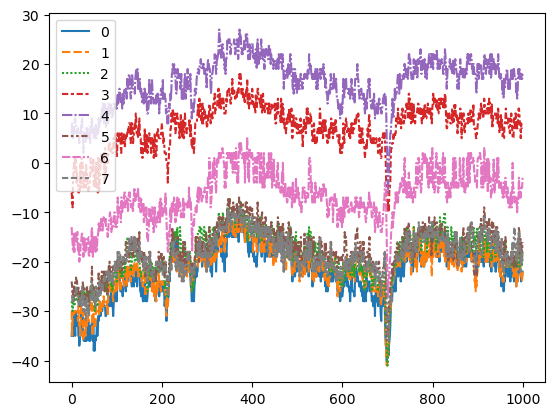

In [12]:
sns.lineplot(rec_raw[0:1000,:])